[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/14_adventures_in_covariance.ipynb)

# Chapter 14 - Adventures in Covariance


## Imports and utility functions


In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.X
    
    !pip install watermark
    !pip install arviz

In [2]:
%load_ext watermark

In [3]:
# Core
import numpy as np
import arviz as az
import pandas as pd
import xarray as xr
import tensorflow as tf
import tensorflow_probability as tfp

# visualization 
import matplotlib.pyplot as plt

# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [4]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas

numpy 1.18.1
tensorflow 2.1.0
tensorflow_probability 0.9.0
arviz 0.6.1
scipy 1.4.1
pandas 0.25.3


In [5]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

In [6]:
assert tf.__version__ >= '2.1.0', "Tensorflow version should be at minimum 2.1.0"
assert tfp.__version__ >= '0.9.0', "TFP version should be at minimum 0.9.0"

## Tensorflow MCMC Sampling helpers


In [7]:
USE_XLA = False

In [8]:
NUMBER_OF_CHAINS  = 2
NUMBER_OF_BURNIN  = 500
NUMBER_OF_SAMPLES = 500
NUMBER_OF_LEAPFROG_STEPS = 4

def _trace_to_arviz(trace=None,
                   sample_stats=None,
                   observed_data=None,
                   prior_predictive=None,
                   posterior_predictive=None,
                   inplace=True):

    if trace is not None and isinstance(trace, dict):
        trace = {k: np.swapaxes(v.numpy(), 1, 0)
                 for k, v in trace.items()}
    if sample_stats is not None and isinstance(sample_stats, dict):
        sample_stats = {k: v.numpy().T for k, v in sample_stats.items()}
    if prior_predictive is not None and isinstance(prior_predictive, dict):
        prior_predictive = {k: v[np.newaxis]
                            for k, v in prior_predictive.items()}
    if posterior_predictive is not None and isinstance(posterior_predictive, dict):
        if isinstance(trace, az.InferenceData) and inplace == True:
            return trace + az.from_dict(posterior_predictive=posterior_predictive)
        else:
            trace = None
            
    # when we are using a single chain
    # arviz messes up the number of chain
    #
    # so here I am providing the coords

    return az.from_dict(
        posterior=trace,
        sample_stats=sample_stats,
        prior_predictive=prior_predictive,
        posterior_predictive=posterior_predictive,
        observed_data=observed_data)


class HMCSampler(object):

    @tf.function(autograph=False, experimental_compile=USE_XLA)
    def run_chain(init_state,
                  bijectors, 
                  step_size, 
                  target_log_prob_fn, 
                  num_leapfrog_steps=NUMBER_OF_LEAPFROG_STEPS,
                  num_samples=NUMBER_OF_SAMPLES,
                  burnin=NUMBER_OF_BURNIN,
                  ):    

        def _trace_fn_transitioned(_, pkr):
            return (
                pkr.inner_results.inner_results.log_accept_ratio
            )
        
        hmc_kernel = tfp.mcmc.HamiltonianMonteCarlo(
                        target_log_prob_fn,
                        num_leapfrog_steps=num_leapfrog_steps,
                        step_size=step_size)         

        inner_kernel = tfp.mcmc.TransformedTransitionKernel(
            inner_kernel=hmc_kernel,
            bijector=bijectors)       

        kernel = tfp.mcmc.SimpleStepSizeAdaptation(
            inner_kernel=inner_kernel,
            target_accept_prob=.8,
            num_adaptation_steps=int(0.8*burnin),
            log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio
        )    

        results, sampler_stat = tfp.mcmc.sample_chain(
            num_results=num_samples,
            num_burnin_steps=burnin,
            current_state=init_state,
            kernel=kernel,
            trace_fn=_trace_fn_transitioned)

        return results, sampler_stat
    
    def sample_from_posterior(jdc, 
                              observed_data, 
                              params, 
                              init_state, 
                              bijectors,                              
                              num_samples=NUMBER_OF_SAMPLES, 
                              burnin=NUMBER_OF_BURNIN):       

        
        target_log_prob_fn = lambda *x: jdc.log_prob(x + observed_data)    

        step_size = 0.1
        
        results, sample_stats = HMCSampler.run_chain(init_state,
                                      bijectors,
                                      step_size=step_size,
                                      target_log_prob_fn=target_log_prob_fn,                                      
                                      num_samples=num_samples, 
                                      burnin=burnin)

        stat_names = ['mean_tree_accept']
        sampler_stats = dict(zip(stat_names, [sample_stats]))    
        
        posterior = dict(zip(params, results))
        
        return _trace_to_arviz(trace=posterior, sample_stats=sampler_stats)

In [9]:
sample_from_posterior = HMCSampler.sample_from_posterior

## Dataset URLs


In [10]:
# You could change base url to local dir or a remoate raw github content
_BASE_URL = "https://raw.githubusercontent.com/ksachdeva/rethinking-tensorflow-probability/master/data"

CHIMPANZEE_DATASET_PATH = f"{_BASE_URL}/chimpanzees.csv"
KOSTER_LECKIE_DATASET_PATH = f"{_BASE_URL}/KosterLeckie.csv"
ISLANDS_DISTMATRIX_DATASET_PATH = f"{_BASE_URL}/islandsDistMatrix.csv"
KLINE_DATASET_PATH = f"{_BASE_URL}/Kline2.csv"
PRIMATES301_DATASET_PATH = f"{_BASE_URL}/Primates301.csv"
PRIMATES301_VCOV_DATASET_PATH = f"{_BASE_URL}/Primates301_vcov_matrix.csv"
PRIMATES301_DISTANCE_DATASET_PATH = f"{_BASE_URL}/Primates301_distance_matrix.csv"

## Code 14.1

Simulate the population

In [11]:
a = 3.5  # average morning wait time
b = -1  # average difference afternoon wait time
sigma_a = 1  # std dev in intercepts
sigma_b = 0.5  # std dev in slopes
rho = -0.7  # correlation between intercepts and slopes

## Code 14.2

In [12]:
Mu = tf.constant([a, b])

The value in a is the mean intercept, the wait in the morning. And the value in b is the mean slope, the difference in wait between afternoon and morning

## Code 14.3

In [13]:
cov_ab = sigma_a * sigma_b * rho
Sigma = tf.constant([[sigma_a ** 2, cov_ab], [cov_ab, sigma_b ** 2]])

## Code 14.4

In [14]:
tf.transpose(tf.reshape(tf.constant([1, 2, 3, 4]), (2, 2)))

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 3],
       [2, 4]], dtype=int32)>

## Code 14.5

In [15]:
sigmas = tf.constant([sigma_a, sigma_b])  # standard deviations
Rho = tf.constant([[1, rho], [rho, 1]])  # correlation matrix

# now matrix multiply to get covariance matrix
Sigma = tf.linalg.tensor_diag(sigmas) @ Rho @ tf.linalg.tensor_diag(sigmas)

Sigma

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 1.  , -0.35],
       [-0.35,  0.25]], dtype=float32)>

## Code 14.6

In [16]:
N_cafes = 20

## Code 14.7

In [17]:
vary_effects = tfd.MultivariateNormalFullCovariance(
    loc=Mu,
    covariance_matrix=Sigma).sample((N_cafes,), seed=5)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


## Code 14.8

In [18]:
a_cafe = vary_effects[:, 0]
b_cafe = vary_effects[:, 1]

In [19]:
b_cafe.shape

TensorShape([20])

## Code 14.9

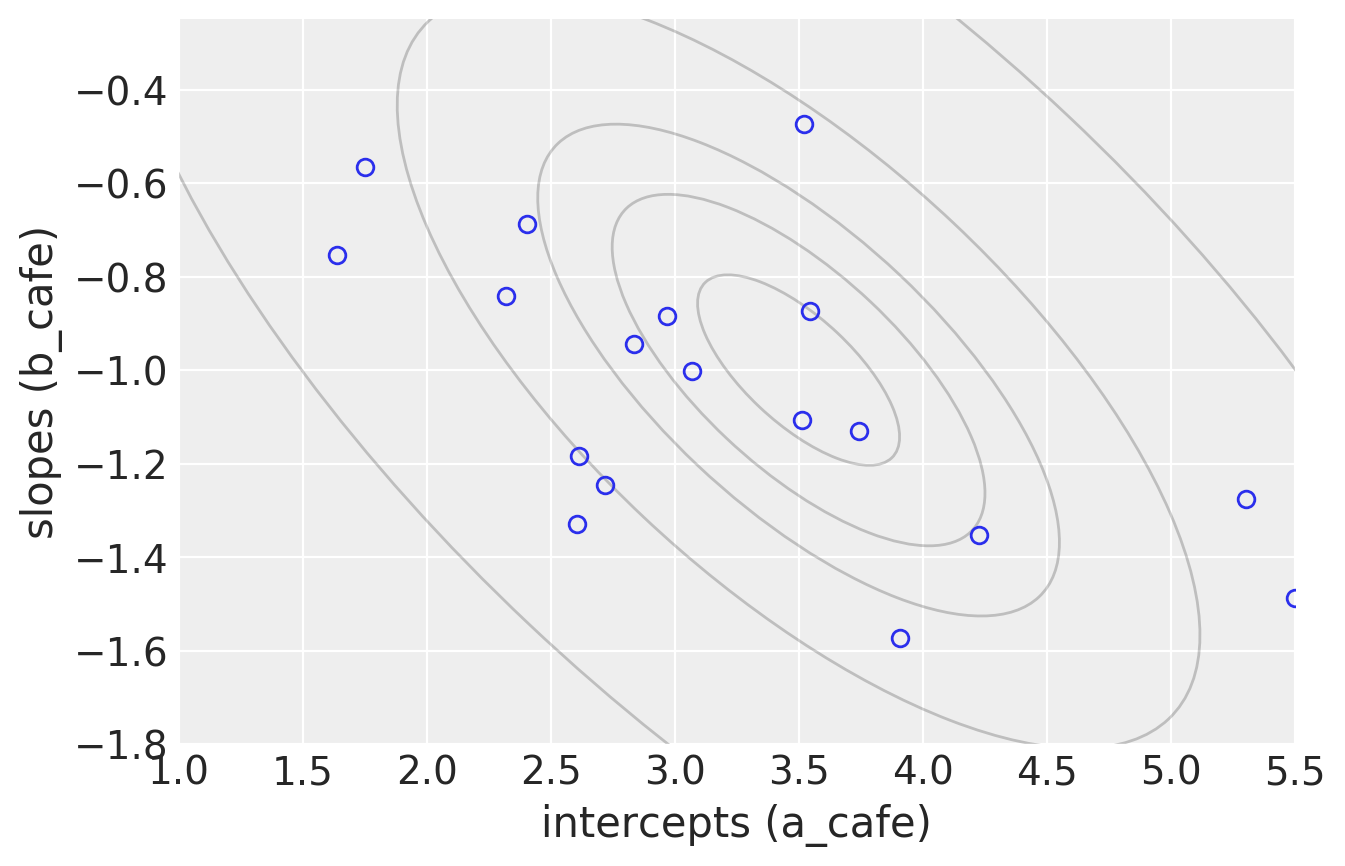

In [20]:
from matplotlib.patches import Ellipse, transforms

plt.plot(a_cafe, b_cafe, "o", mfc="none")
plt.gca().set(xlabel="intercepts (a_cafe)", ylabel="slopes (b_cafe)")
plt.xlim((1.0,5.5))
plt.ylim((-1.8,-0.25))

# overlay population distribution
# Ref: https://matplotlib.org/gallery/statistics/confidence_ellipse.html
for l in [0.1, 0.3, 0.5, 0.8, 0.99]:
    pearson = Sigma[0, 1] / np.sqrt(Sigma[0, 0] * Sigma[1, 1])
    ellipse = Ellipse((0, 0), np.sqrt(1 + pearson), np.sqrt(1 - pearson),
                      edgecolor="k", alpha=0.2, facecolor="none")
    std_dev = tfd.Normal(loc=0.,scale=1.).quantile((1 + np.sqrt(l)) / 2)
    scale_x = 2 * std_dev * np.sqrt(Sigma[0, 0])
    scale_y = 2 * std_dev * np.sqrt(Sigma[1, 1])
    scale = transforms.Affine2D().rotate_deg(45).scale(scale_x, scale_y)
    ellipse.set_transform(scale.translate(Mu[0], Mu[1]) + plt.gca().transData)
    plt.gca().add_patch(ellipse)

## Code 14.10

The data we’re generating describes the waiting times in 20 different cafés. Each café has a different average waiting times in the morning and in the afternoon. The average morning waiting time is the intercept, and the difference between afternoon and morning average waiting times is the slope. 

In [21]:
N_visits = 10
afternoon = np.tile(np.arange(2), N_visits * N_cafes // 2)
cafe_id = np.repeat(np.arange(N_cafes), N_visits)
mu = tf.gather(a_cafe, cafe_id) + tf.gather(b_cafe, cafe_id) * afternoon
sigma = 0.5  # std dev within cafes
wait = tfd.Normal(loc=mu, scale=sigma).sample(seed=22)
d = pd.DataFrame(dict(cafe=cafe_id, afternoon=afternoon, wait=wait))

d

,cafe,afternoon,wait
0,0,0,1.770887
1,0,1,2.048674
2,0,0,2.285792
3,0,1,1.656177
4,0,0,3.005670
...,...,...,...
195,19,1,4.088935
196,19,0,5.800627
197,19,1,4.087051
198,19,0,5.577837


## Code 14.11

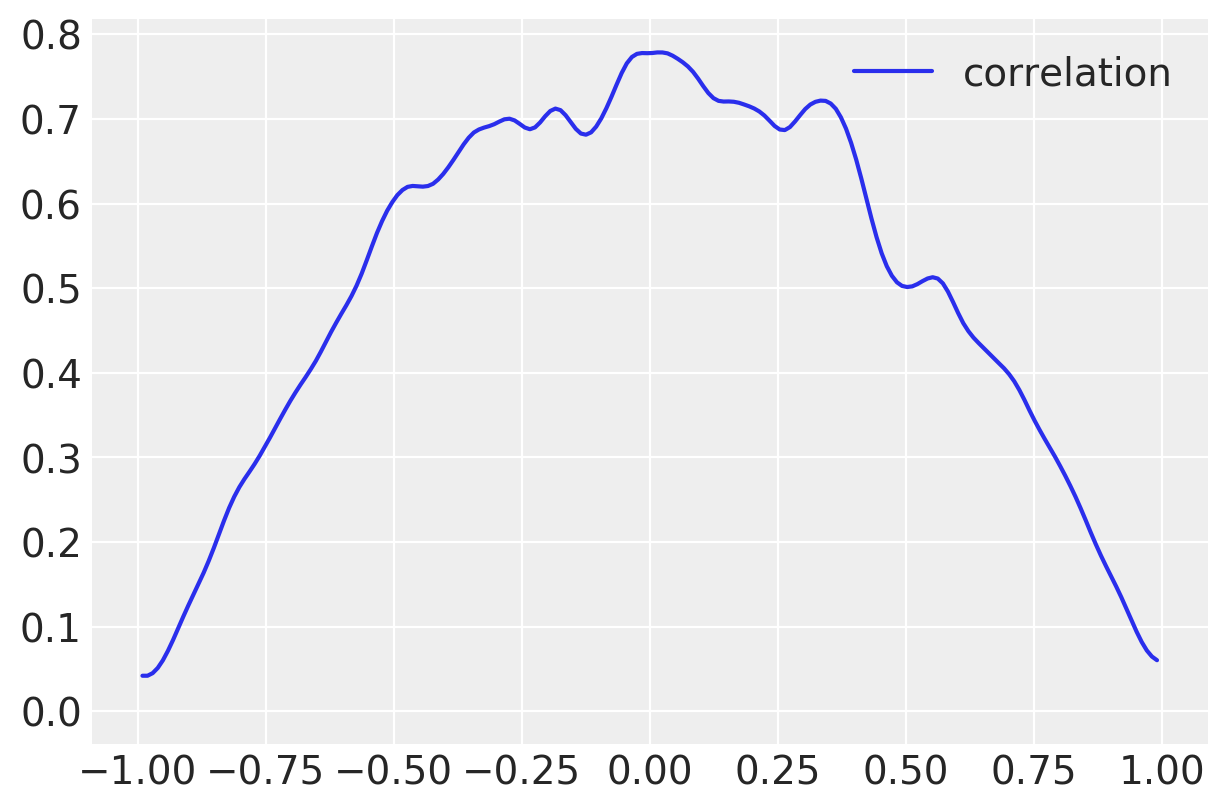

In [22]:
R = tfp.distributions.LKJ(dimension=2, concentration=2).sample((int(1e4),))
az.plot_kde(R[:, 0, 1], bw=2, label="correlation");

In [23]:
R.shape

TensorShape([10000, 2, 2])

## Code 14.12

In [24]:
def model_14_1(cafe, afternoon):
    def _generator():
        alpha = yield Root(tfd.Sample(tfd.Normal(loc=5.,scale=2.), sample_shape=1))
        beta  = yield Root(tfd.Sample(tfd.Normal(loc=-1., scale=0.5), sample_shape=1))
        sigma_cafe = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=2))
        sigma = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
        Rho = yield Root(tfp.distributions.LKJ(dimension=2, concentration=2.))
        
        Mu = tf.concat([alpha, beta], axis=-1)
        
        a_cafe_b_cafe = yield tfd.Sample(
                tfd.MultivariateNormalTriL(
                        loc = Mu,
                        scale_tril = tf.linalg.LinearOperatorDiag(sigma_cafe).matmul(Rho)
                    ),sample_shape=20)

        a_cafe = a_cafe_b_cafe[:,0]
        b_cafe = a_cafe_b_cafe[:,1]
        
        term1 = tf.gather(a_cafe, cafe, axis=-1)
        term2 = tf.gather(b_cafe, cafe, axis=-1)
    
        mu = term1 + term2 * afternoon
        
        wait = yield tfd.Independent(
            tfd.Normal(loc=mu, scale=sigma),
            reinterpreted_batch_ndims=1)
        
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False) 
        
        
jdc_14_1 = model_14_1(d.cafe.values, d.afternoon.values)
        
jdc_14_1.sample()

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([5.4276066], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-2.126624], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1.7250053, 1.5252798], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.008814], dtype=float32)>,
 <tf.Tensor: shape=(2, 2), dtype=float32, numpy=
 array([[1.        , 0.02255547],
        [0.02255547, 1.        ]], dtype=float32)>,
 <tf.Tensor: shape=(20, 2), dtype=float32, numpy=
 array([[ 6.8354445 , -2.7458382 ],
        [ 4.933817  , -3.6447384 ],
        [ 4.6182632 , -2.046766  ],
        [ 5.7923374 ,  0.5039921 ],
        [ 6.713848  , -1.0449814 ],
        [ 8.350418  , -1.8908081 ],
        [ 3.8624666 , -3.1996503 ],
        [ 3.8920205 , -4.13902   ],
        [ 3.6104627 ,  0.6997037 ],
        [ 2.0272887 , -1.1142223 ],
        [ 7.7352715 , -2.1858559 ],
        [ 3.140615  , -0.25041926],
        [ 6.9728293 , -1.8964273 ],
        [

In [25]:
alpha_init, beta_init, sigma_cafe_init, sigma_init, Rho_init, a_cafe_b_cafe_init, _ = jdc_14_1.sample()

# let's see Rho and make sure that what we have
# looks like a correlation matrix as a sanity check
#
# Now this will a prior sample so most likely
# we will get the correct sample however when we will do HMC
# we maybe extra care
Rho_init

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1.       , 0.3028338],
       [0.3028338, 1.       ]], dtype=float32)>

In [26]:
init_state = [
    alpha_init,
    beta_init,
    sigma_cafe_init,
    sigma_init,
    Rho_init,
    a_cafe_b_cafe_init
]

bijectors = [
    tfb.Identity(),  # alpha
    tfb.Identity(),  # beta
    tfb.Exp(),       # sigma_cafe
    tfb.Exp(),       # sigma
    tfb.CorrelationCholesky(),  # Rho
    tfb.Identity(),  # a_cafe_b_cafe
]

observed_data = (tf.cast(d.wait.values, dtype=tf.float32),)

# Not working !
# trace_14_1 = sample_from_posterior(
#                     jdc_14_1, 
#                     observed_data=observed_data,
#                     params=['alpha', 'beta', 'sigma_cafe', 'sigma', 'Rho', 'a_cafe_b_cafe'],
#                     num_samples=1000,
#                     burnin=500,
#                     init_state=init_state,
#                     bijectors=bijectors
#                     )

## Code 14.13- 14.17  (Not implented as above section is not working !)

## Code 14.18

In [60]:
d = pd.read_csv(CHIMPANZEE_DATASET_PATH, sep=";")
d["block_id"] = d.block
d["treatment"] = 1 + d.prosoc_left + 2 * d.condition

dat = dict(L=d.pulled_left.values, tid=d.treatment.values - 1,
           actor=d.actor.values - 1, block_id=d.block_id.values - 1)

# actor 0 to 6 => 7
# tid 0 to 3 => 4

In [61]:
def model_14_2(tid, actor, block_id, num_chains):
    
    # we need to create the indexes that make
    # gather_nd happy
    actor_tid = tf.stack([actor, tid], axis=1)
    block_tid = tf.stack([block_id, tid], axis=1)
    batch_dims = 0
    
    if num_chains > 1:
        actor_tid_tiled =  tf.tile(actor_tid, (num_chains, 1))
        actor_tid_reshaped = tf.reshape(actor_tid_tiled, (num_chains, 504, 2))
        
        actor_tid = actor_tid_reshaped
        
        block_tid_tiled =  tf.tile(block_tid, (num_chains, 1))
        block_tid_reshaped = tf.reshape(block_tid_tiled, (num_chains, 504, 2))
        
        block_tid = block_tid_reshaped
        
        batch_dims = 1
        
    
    def _generator():
        # fixed priors
        g = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=4))
        sigma_actor = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=4))
        # note - not using Sample as it does not work with it
        rho_actor = yield Root(tfp.distributions.LKJ(dimension=4, concentration=4.))
        sigma_block = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=4))
        # note - not using Sample as it does not work with it
        rho_block = yield Root(tfp.distributions.LKJ(dimension=4, concentration=4.))
        # adaptive priors
        
        alpha = yield tfd.Sample(
                tfd.MultivariateNormalTriL(
                        loc = 0.,
                        scale_tril = tf.linalg.LinearOperatorDiag(sigma_actor).matmul(rho_actor)
                    ),sample_shape=7)
        
        beta = yield tfd.Sample(
                tfd.MultivariateNormalTriL(
                        loc = 0.,
                        scale_tril = tf.linalg.LinearOperatorDiag(sigma_block).matmul(rho_block)
                    ),sample_shape=6)
        
  
        print(alpha.shape)

        term1 = tf.gather(g, tid, axis=-1)
        term2 = tf.gather_nd(alpha, actor_tid, batch_dims=batch_dims)
        term3 = tf.gather_nd(alpha, block_tid, batch_dims=batch_dims)
        
        logit_p =  term1 + term2 + term3
        
        L = yield tfd.Independent(tfd.Binomial(total_count=1, logits=logit_p), reinterpreted_batch_ndims=1)
        
        
    return tfd.JointDistributionCoroutine(_generator, validate_args=False) 
        
    
jdc_14_2 = model_14_2(dat["tid"], dat["actor"], dat["block_id"], num_chains=1)

jdc_14_2.sample()

(7, 4)


(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.34177905, -0.28596163,  0.00334189, -0.6411293 ], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.02672422, 3.3206892 , 0.82678264, 3.1521685 ], dtype=float32)>,
 <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
 array([[ 1.        ,  0.08402777, -0.13147444, -0.38071358],
        [ 0.08402777,  1.        , -0.20615253,  0.13412783],
        [-0.13147444, -0.20615253,  1.        , -0.2349674 ],
        [-0.38071358,  0.13412783, -0.2349674 ,  1.        ]],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.16662279, 0.09219509, 1.058483  , 0.4313959 ], dtype=float32)>,
 <tf.Tensor: shape=(4, 4), dtype=float32, numpy=
 array([[ 1.        , -0.0059855 ,  0.04524606, -0.16377744],
        [-0.0059855 ,  1.        , -0.11170421,  0.30325863],
        [ 0.04524606, -0.11170421,  1.        ,  0.03799928],
        [-0.16377744,  0.30325863,  0.03799928,  1.        ]],
       dtype=float3

In [62]:
g_init, sigma_actor_init, rho_actor_init, sigma_block_init, rho_block_init, alpha_init, beta_init, _ = jdc_14_2.sample()

(7, 4)


In [63]:
init_state = [
    g_init,
    sigma_actor_init,
    rho_actor_init, 
    sigma_block_init, 
    rho_block_init, 
    alpha_init, 
    beta_init,
]

bijectors = [
    tfb.Identity(),
    tfb.Exp(),
    tfb.CorrelationCholesky(),
    tfb.Exp(),
    tfb.CorrelationCholesky(),
    tfb.Identity(),
    tfb.Identity()
]


observed_data = (tf.cast(dat["L"], dtype=tf.float32),)

trace_14_2 = sample_from_posterior(
                    jdc_14_2, 
                    observed_data=observed_data,
                    params=['g', 'sigma_actor', 'rho_actor', 'sigma_block', 'rho_block', 'alpha', 'beta'],
                    num_samples=2000,
                    burnin=500,
                    init_state=init_state,
                    bijectors=bijectors
                    )

(7, 4)
(7, 4)
(7, 4)
(7, 4)


What is happening is that arviz assigns 7 to the chain dimension and this screws up the
entire structure in xarray. Really arviz does not work if there is 1 chain. 

Now I have problem using 2 chains so that is the real problem indeed !

In [64]:
trace_14_2.posterior

<xarray.Dataset>
Dimensions:          (alpha_dim_0: 4, beta_dim_0: 4, chain: 7, draw: 2000, rho_actor_dim_0: 4, rho_block_dim_0: 4)
Coordinates:
  * chain            (chain) int64 0 1 2 3 4 5 6
  * draw             (draw) int64 0 1 2 3 4 5 ... 1994 1995 1996 1997 1998 1999
  * rho_actor_dim_0  (rho_actor_dim_0) int64 0 1 2 3
  * rho_block_dim_0  (rho_block_dim_0) int64 0 1 2 3
  * alpha_dim_0      (alpha_dim_0) int64 0 1 2 3
  * beta_dim_0       (beta_dim_0) int64 0 1 2 3
Data variables:
    g                (chain, draw) float32 0.3868428 0.3868428 ... nan nan
    sigma_actor      (chain, draw) float32 0.81423 0.81423 0.81423 ... nan nan
    rho_actor        (chain, draw, rho_actor_dim_0) float32 1.0 0.0 ... nan nan
    sigma_block      (chain, draw) float32 1.2745494 1.2745494 ... nan nan
    rho_block        (chain, draw, rho_block_dim_0) float32 1.0 0.0 ... nan nan
    alpha            (chain, draw, alpha_dim_0) float32 -0.70796466 ... 3.1083994
    beta             (chain, draw, beta_dim_0) float32 -1.6643802 ... nan
Attributes:
    created_at:  2020-02-17T01:10:15.719635

In [65]:
az.summary(trace_14_2)

arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.
arviz.stats.stats_utils - WARNING - Array contains NaN-value.


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
g,0.411,0.500,-1.717,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sigma_actor,0.771,0.432,0.068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rho_actor[0],0.572,0.352,-0.703,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rho_actor[1],0.344,0.397,-0.734,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rho_actor[2],0.248,0.336,-0.704,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rho_actor[3],0.151,0.276,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sigma_block,0.928,0.807,0.054,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rho_block[0],0.226,0.563,-0.919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rho_block[1],0.225,0.467,-0.910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
rho_block[2],0.212,0.404,-0.851,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
